# Introduction

<img src="hawkins_and_sutton_pic.png" alt="Drawing" style="width: 400px;"/>

Figure shows the relative importance of different sources of uncertainty in global decdadal mean surface air temperature, from [Hawkins and Sutton (2009)](https://journals.ametsoc.org/doi/pdf/10.1175/2009BAMS2607.1). Internal model variability is expected to play a negligble role in climate uncertainty after mid-century. However, the _impacts_ of climate change often depend on climate in non-linear ways, which may cause this uncertainty to be amplified or depressed. This project uses 50 runs of the MPI Grand Ensemble together with a well-known damage function for heat-related mortality to study the relative importance of internal model variability on projections of changes in mortality due to climate change in the continental United States. 

# Setup

In [1]:
import xarray as xr
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xesmf as xe
import regionmask
import cartopy.crs as ccrs

In [3]:
# Map setups, for consistency
proj_kwargs = {'central_longitude':260,
               'standard_parallels':(29.5,45.5)}

# Load Data

In [4]:
# Load data
data_era_hist = xr.open_dataset("data/tas_12hr_ERA-INTERIM_historical_reanalysis_19800101-19991231.nc")
data_mpi_hist = xr.open_dataset("data/tas_Amon_MPI-ESM_historical_RUNS1-50_19800101-19991231_CUSA.nc")
data_mpi_rcp85_midc = xr.open_dataset("data/tas_Amon_MPI-ESM_rcp85_RUNS1-50_20400101-20591231_CUSA.nc")
data_mpi_rcp85_endc = xr.open_dataset("data/tas_Amon_MPI-ESM_rcp85_RUNS1-50_20800101-20991231_CUSA.nc")

# Preprocessing Historical Data
ERA-INTERIM temperature comes in 12-hour steps; datapoints are averaged per full day to get average daily temperature

In [5]:
# Take average per day
data_era_hist = data_era_hist.groupby(data_era_hist.time.dt.floor('D')).mean()

In [6]:
# Switch to the same names as in the mpi-ge datasets
data_era_hist = data_era_hist.rename({'floor':'time','longitude':'lon','latitude':'lat','t2m':'tas'})

In [7]:
# Switch longitude to 0-360, as in mpi-ge (ERA data is already 
# subsetted to CUSA (all lons are negative), so 360+[lon] is 
# sufficient)
data_era_hist = data_era_hist.assign_coords({'lon':360+data_era_hist.lon})

In [8]:
# Set attributes, for display convenience
data_era_hist.lon.attrs={'units':'degrees_east','long_name':'longitude'}
data_era_hist.tas.attrs={'units':'K','long_name':'Near-Surface Air Temperature'}
data_mpi_hist.lon.attrs={'units':'degrees_east','long_name':'longitude'}
data_mpi_hist.lat.attrs={'units':'degrees_north','long_name':'latitude'}
data_mpi_hist.tas.attrs={'units':'K','long_name':'Near-Surface Air Temperature'}

In [10]:
# Build regridder to MPI grid
regridder = xe.Regridder(data_era_hist,data_mpi_hist,'bilinear')

Overwrite existing file: bilinear_38x81_19x35.nc 
 You can set reuse_weights=True to save computing time.


In [174]:
# Regrid to MPI grid; with the exception to deal with the 
# (still unresolved) binder-xesmf issue - in this case a 
# regridded version of the dataset is loaded from file (this 
# backup was created offline, where the issue is not present)
try:
    data_era_hist_rg = regridder(data_era_hist)
    1/0
except: 
    data_era_hist_rg = xr.open_dataset("data/data_era_hist_rg_regridderworkaround.nc")

using dimensions ('lat', 'lon') from data variable tas as the horizontal dimensions for this dataset.


In [172]:
# Saved to allow workaround above
#data_era_hist_rg.to_netcdf('data/data_era_hist_rg_regridderworkaround.nc')

In [12]:
# Replace 0s with nans
data_era_hist_rg = data_era_hist_rg.where(data_era_hist_rg.tas.mean('time')>0)

## Illustration of regridding ERA-INTERIM to the MPI-GE grid
(arguments could be made in favor of regridding MPI-GE to the ERA-INTERIM grid due to the use of a delta-method to project; a future realiziation could contrast the two approaches)

/anaconda3/envs/my_environment/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


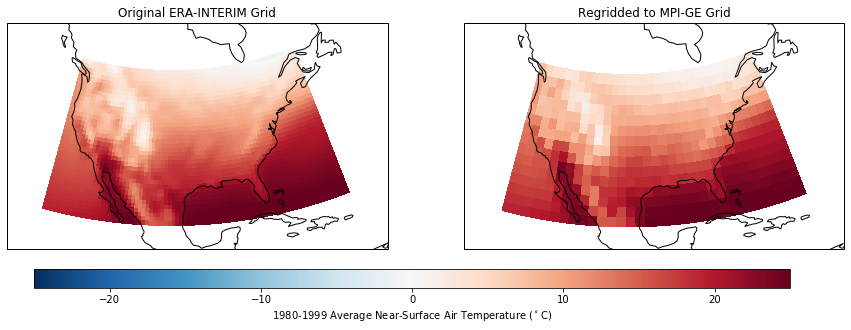

In [13]:
## Create figure
fig = plt.figure(figsize=(15, 20))

# Set colormap
cmap = mpl.cm.get_cmap('RdBu_r')
#bounds = np.linspace(-25, 25, 26)
#norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
# Set color limits
vs = [-25,25]

ax0 = plt.subplot(1, 2, 1, projection=ccrs.AlbersEqualArea(**proj_kwargs))
((data_era_hist.mean('time').tas-273.15)
     .plot(transform=ccrs.PlateCarree(),
           add_colorbar=False,
           cmap=cmap,vmin=vs[0],vmax=vs[1])) # norm=norm
ax0.coastlines()
ax0.set_extent((-130,-60,15,55))
ax0.set_title('Original ERA-INTERIM Grid')


ax1 = plt.subplot(1, 2, 2, projection=ccrs.AlbersEqualArea(**proj_kwargs))
((data_era_hist_rg.mean('time').tas-273.15)
     .plot(transform=ccrs.PlateCarree(),
           add_colorbar=False,
           cmap=cmap,vmin=vs[0],vmax=vs[1])) 
ax1.coastlines()
ax1.set_extent((-130,-60,15,55))
ax1.set_title('Regridded to MPI-GE Grid')

## Add the colorbar
# Create axis for colorbar
cbar_ax = fig.add_axes([0.15,0.36,0.7,0.05],visible=False)
# Add colorbar
cb=fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vs[0],vmax=vs[1]), 
                                   cmap=cmap),
                orientation='horizontal',
            ax=cbar_ax,pad=0,fraction=1,aspect=40)
cb.set_label("1980-1999 Average Near-Surface Air Temperature ($^\circ$C)")

# Delta-method projection
A 'delta-method' projection of the historic weather data into mid- and end-of-century is constructed by adding monthly mean changes from MPI-GE to the historical ERA-INTERIM data. In this way, 50 future projections of daily temperature data are created each for the periods 2040-2059 and 2080-2099. The day-to-day variability structure (which the models are known to treat poorly) of the reanalysis data is preserved, but large-scale changes in the mean and the seasonal cycle of the model are added. 

In [14]:
dT_midc = data_mpi_rcp85_midc.groupby('time.month').mean()-data_mpi_hist.groupby('time.month').mean()
dT_endc = data_mpi_rcp85_endc.groupby('time.month').mean()-data_mpi_hist.groupby('time.month').mean()

In [15]:
def delta_midc(x):
    return x + dT_midc.tas[x.time.dt.month-1,:,:,:]

data_era_proj_midc = data_era_hist_rg.groupby('time.month').apply(delta_midc)

In [16]:
def delta_endc(x):
    return x + dT_endc.tas[x.time.dt.month-1,:,:,:]

data_era_proj_endc = data_era_hist_rg.groupby('time.month').apply(delta_endc)

## Illustration of the mid- and end-of-century projections

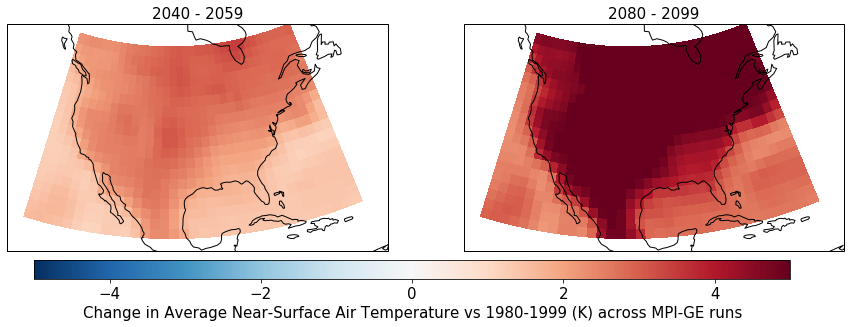

In [168]:
plot_params = {'data':[dT_midc.tas.mean(("run","month")),
                       dT_endc.tas.mean(("run","month"))],
               'titles':['2040 - 2059','2080 - 2099'],
                'vs':[-5,5],'cmap':mpl.cm.get_cmap('RdBu_r')}


def proj_plot(plot_params):
    # Create figure
    fig = plt.figure(figsize=(15, 20))
    for plt_idx in np.arange(0,len(plot_params['data'])):
        ax = plt.subplot(1,2,plt_idx+1,projection=ccrs.AlbersEqualArea(**proj_kwargs))
        (plot_params['data'][plt_idx]
           .plot(transform=ccrs.PlateCarree(),
           add_colorbar=False,
           cmap=plot_params['cmap'],
           vmin=plot_params['vs'][0],vmax=plot_params['vs'][1]))
        ax.coastlines()
        ax.set_extent((-130,-60,15,55))
        ax.set_title(plot_params['titles'][plt_idx],size=15)
        
    return(fig)

fig = proj_plot(plot_params)

## Add the colorbar
# Bump everything over to make room for master colorbar
fig.subplots_adjust(bottom=0.15)
# Create axis for colorbar
cbar_ax = fig.add_axes([0.15,0.38,0.7,0.05],visible=False)
# Add colorbar
cb=fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=plot_params['vs'][0],
                                                                vmax=plot_params['vs'][1]), 
                                   cmap=plot_params['cmap']),
                orientation='horizontal',
            ax=cbar_ax,pad=0,fraction=1,aspect=40)
cb.set_label("Change in Average Near-Surface Air Temperature vs 1980-1999 (K) across MPI-GE runs",size=15)
cb.ax.tick_params(labelsize=15)

## An Illustration of differences between projections built with different MPI-GE runs

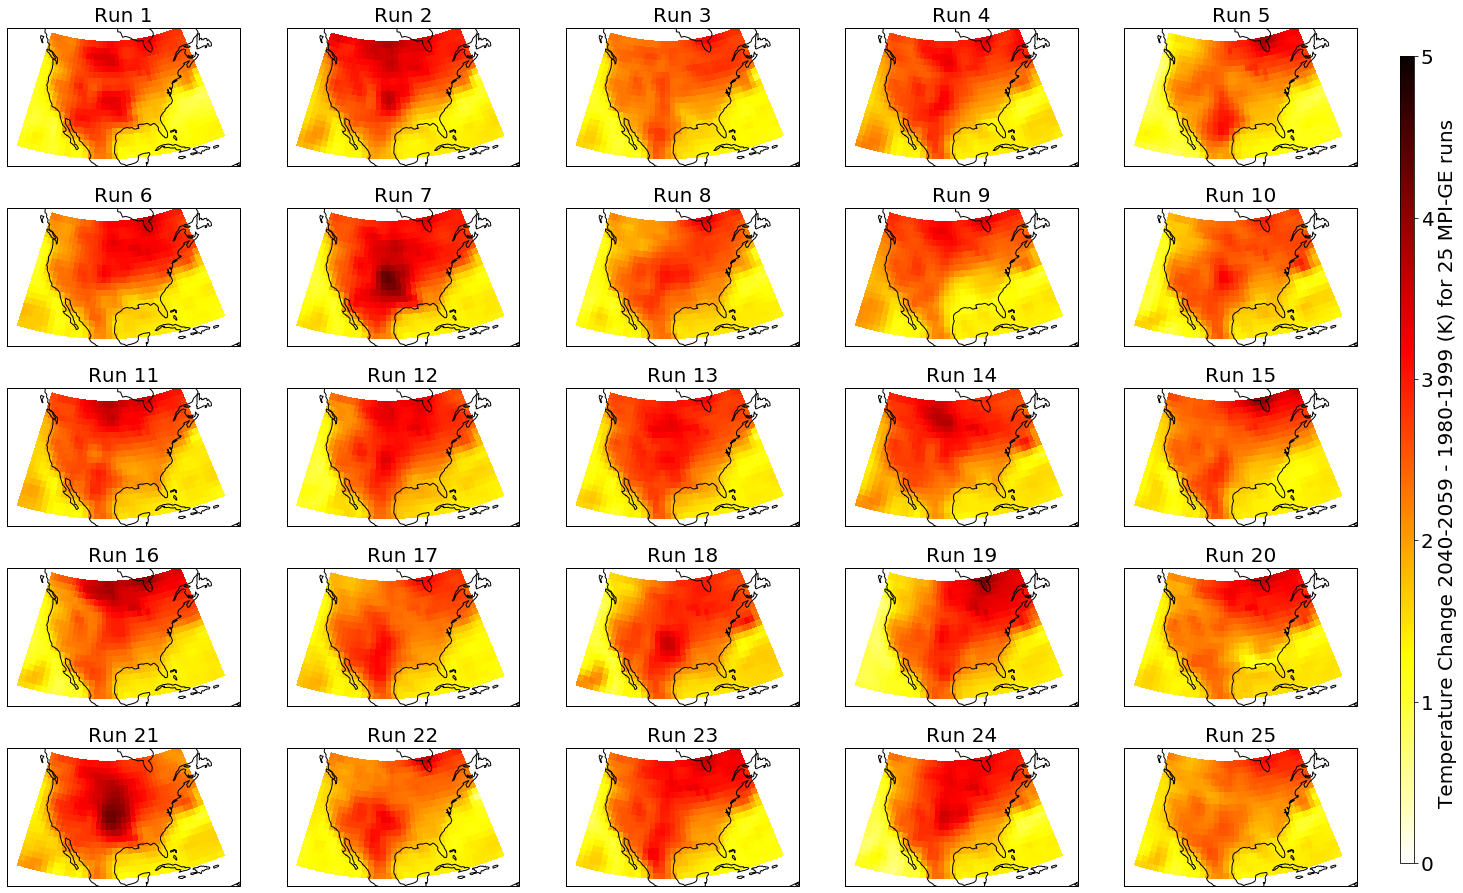

In [18]:
## Create figure
fig = plt.figure(figsize=(30,16))

# Set colormap
cmap = mpl.cm.get_cmap('hot_r')
# Set color limits
vs = [0,5]

# #data_mpi_hist.run.values
for run_idx in np.arange(0,25):
    ax0 = plt.subplot(5, 5, run_idx+1, projection=ccrs.AlbersEqualArea(**proj_kwargs))
    (dT_midc.tas[:,run_idx,:,:].mean("month")
         .plot(transform=ccrs.PlateCarree(),
           add_colorbar=False,
           cmap=cmap,vmin=vs[0],vmax=vs[1]))
    ax0.coastlines()
    ax0.set_extent((-130,-60,15,55))
    ax0.set_title('Run '+str(run_idx+1),size=20)
    
## Add the colorbar
# Bump everything over to make room for master colorbar
fig.subplots_adjust(right=0.75)
# Create axis for colorbar
cbar_ax = fig.add_axes([0.77, 0.15, 0.15, 0.7],visible=False)
# Add colorbar
cb=fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vs[0],vmax=vs[1]), 
                                   cmap=cmap),
                orientation='vertical',
            ax=cbar_ax,fraction=1,aspect=60)
cb.set_label("Temperature Change 2040-2059 - 1980-1999 (K) for 25 MPI-GE runs ",size=20)
cb.ax.tick_params(labelsize=20)

# Change in Mortality Rate
Using the damage function from [Deschenes and Greenstone (2011)](https://www.aeaweb.org/articles?id=10.1257/app.3.4.152),

In [19]:
drate_dmgf = xr.DataArray([0.69,0.59,0.64,0.36,0.27,0,0.12,0.23,0.33,0.94],dims=['bin'],coords=[np.arange(1,11)])
bins = np.append(np.append(-np.inf,(np.arange(10,91,10)+459.67)*5/9),np.inf)

the change in annual mortality due to temperature changes in calculated for each projection, mid-century and end-of-century. The damage function relates days in a year within temperature bins (set in Farenheidt) to corresponding increases in mortality versus an 'ideal' temperature (Americans on average seem to thrive most around 50-60 degrees Farenheidt). All days in the historical period and in the 50 projections for the mid- and end-of-century time periods are sorted into temperature bins, and the number of days in each bin per year is averaged in each period.

In [145]:
# Change to Farenheidt, divide by 10 and get floor to get the right bin indices
# Replace values beyond the bins with the closest bin, and make integer
def get_bin_indices(tas):
    x = np.floor((((tas*9/5)-459.67)/10))
    x = x.where(x>0,0.).where(x<9,9).astype(int)
    x = x.where(~np.isnan(tas),np.nan)
    return(x+1)

data_era_hist_rg['bins'] = get_bin_indices(data_era_hist_rg.tas)
data_era_proj_midc['bins'] = get_bin_indices(data_era_proj_midc.tas)
data_era_proj_endc['bins'] = get_bin_indices(data_era_proj_endc.tas)

# As far as I understand it, groupby_bins doesn't work here because 
# it's being done on the (3/4-D) *variable* instead of a dimension, 
# and pandas.cut doesn't like multiple dimensions. Maybe I'll open a ticket.
#gb = data_era_hist_rg.groupby_bins('tas',bins)
#gb.count() # <- couldn't find a way to make this keep original 
# coordinates, without looping over the group_ds'es with 
# group_ds.unstack().count("time").tas, which is not great 
# performance-wise in addition to being a syntactic mess

In [116]:
data_era_hist_rg.tas[0,5,5]

<xarray.DataArray 'tas' ()>
array(289.66653488)
Coordinates:
    time     datetime64[ns] 1980-01-01
    lon      float64 241.9
    lat      float64 30.78

In [144]:
tas = np.array([260,270,280,290,300,305,308,230,280])
print((tas*9/5)-459.67)
x = np.floor((((tas*9/5)-459.67)/10))
print(x)
x[x<0]=0; x[x>9]=9
print(x)

[  8.33  26.33  44.33  62.33  80.33  89.33  94.73 -45.67  44.33]
[ 0.  2.  4.  6.  8.  8.  9. -5.  4.]
[0. 2. 4. 6. 8. 8. 9. 0. 4.]


In [146]:
# Create a new dataset to store bin and mortality information
dbins = xr.Dataset({'hist' : (['lat','lon','bin'],np.zeros((data_era_hist_rg.dims['lat'],data_era_hist_rg.dims['lon'],len(bins)-1))),
                   'midc' : (['lat','lon','run','bin'],np.zeros((data_era_hist_rg.dims['lat'],data_era_hist_rg.dims['lon'],data_era_proj_midc.dims['run'],len(bins)-1))),
                   'endc' : (['lat','lon','run','bin'],np.zeros((data_era_hist_rg.dims['lat'],data_era_hist_rg.dims['lon'],data_era_proj_midc.dims['run'],len(bins)-1)))},
                  coords={'lon' : (['lon'],data_era_proj_midc.lon),
                           'lat' : (['lat'],data_era_proj_midc.lat),
                           'bin' : (['bin'],np.arange(1,11)),
                           'run' : (['run'],np.arange(0,50))})

In [147]:
# Average per year
for bin_idx in np.arange(1,11):
    dbins['hist'].loc[dict(bin=bin_idx)] = (data_era_hist_rg.bins==bin_idx).sum("time")/20
    dbins['midc'].loc[dict(bin=bin_idx)] = (data_era_proj_midc.bins==bin_idx).sum("time")/20
    dbins['endc'].loc[dict(bin=bin_idx)] = (data_era_proj_endc.bins==bin_idx).sum("time")/20

Finally, the change in average bin-days / year between the mid-/end-of-century and historical periods is calculated, and the pixel-wise change in mortality rate is calculated by a simple matrix multiplication of bin-days per location/run with the damage function.

In [148]:
# Get change in bin-days/year
dbins['dmidc'] = dbins.midc-dbins.hist
dbins['dendc'] = dbins.endc-dbins.hist

In [149]:
# Get change in mortality rate
dbins['drate_midc'] = dbins.dmidc.stack(coor=('lat','lon','run')).dot(drate_dmgf).unstack()
dbins['drate_endc'] = dbins.dendc.stack(coor=('lat','lon','run')).dot(drate_dmgf).unstack()

## Plots

Changes in mortality rate from climate change are estimated using the damage function from [Deschenes and Greenstone (2011)](https://www.aeaweb.org/articles?id=10.1257/app.3.4.152), showing the impact of an extra day with an average temperature within a certain bin on annual mortality. This damage function was calculated using county-level data from the continental United States. 

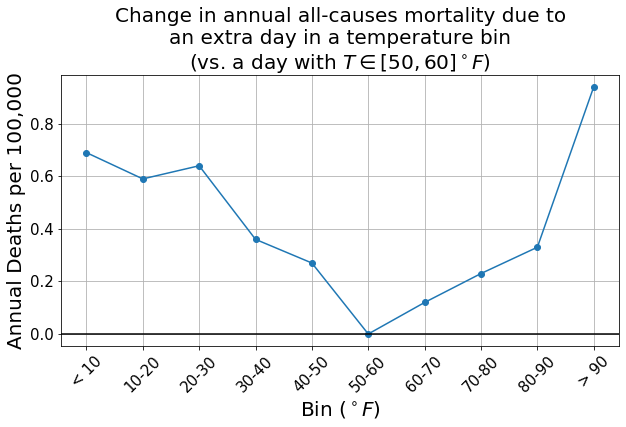

In [25]:
fig,ax = plt.subplots(figsize=(10,5))

drate_dmgf.plot(marker='o')

ax.grid()
ax.axhline(color='k')

ax.set_xlabel('Bin ($^\circ F$)',size=20)
ax.set_xticks(np.arange(1,11))
ax.set_xticklabels(['< 10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','> 90'],rotation=45)

ax.set_ylabel('Annual Deaths per 100,000',size=20)

ax.set_title('Change in annual all-causes mortality due to\nan extra day in a temperature bin\n(vs. a day with $T \in [50,60] ^\circ F$)',size=20)

ax.tick_params(labelsize=15)

In [26]:
# Set mask for the United States
mask = regionmask.defined_regions.natural_earth.countries_110.mask(dbins,wrap_lon=True)

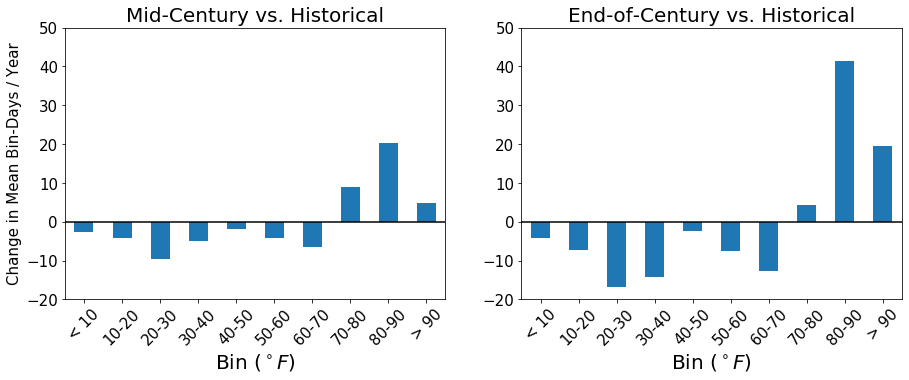

In [150]:
plot_params = {'data':[dbins.where(mask==4).mean(('run','lat','lon')).dmidc,
                       dbins.where(mask==4).mean(('run','lat','lon')).dendc],
              'titles':['Mid-Century vs. Historical','End-of-Century vs. Historical'],
              'ylabels':['Change in Mean Bin-Days / Year','']}

## Plotting Function
def hist_plot(plot_params):
    fig = plt.figure(figsize=(15,5))
    for run_idx in np.arange(0,len(plot_params['data'])):
        ax = plt.subplot(len(plot_params['data'])/2, 2, run_idx+1)
        plot_params['data'][run_idx].to_series().plot.bar()
        ax.axhline(color='k')
        ax.set_xlabel('Bin ($^\circ F$)',size=20)
        ax.set_xticks(np.arange(0,10))
        ax.set_xticklabels(['< 10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','> 90'],rotation=45)
        ax.set_ylim([-20,50])
        ax.set_ylabel(plot_params['ylabels'][run_idx],size=15)
        ax.set_title(plot_params['titles'][run_idx],size=20)
        ax.tick_params(labelsize=15)

hist_plot(plot_params)


The figure above shows changes in number of bin-days per year between the two time periods and the historical period (mean across all 50 projections and across the continental United States. This is a geographic mean, and does not weight by population). In line with preivous work, climate change results in an increase in hot days at the expense of cold days, with the largest increase being in the number of days in the 80-90$^\circ$ bin. 

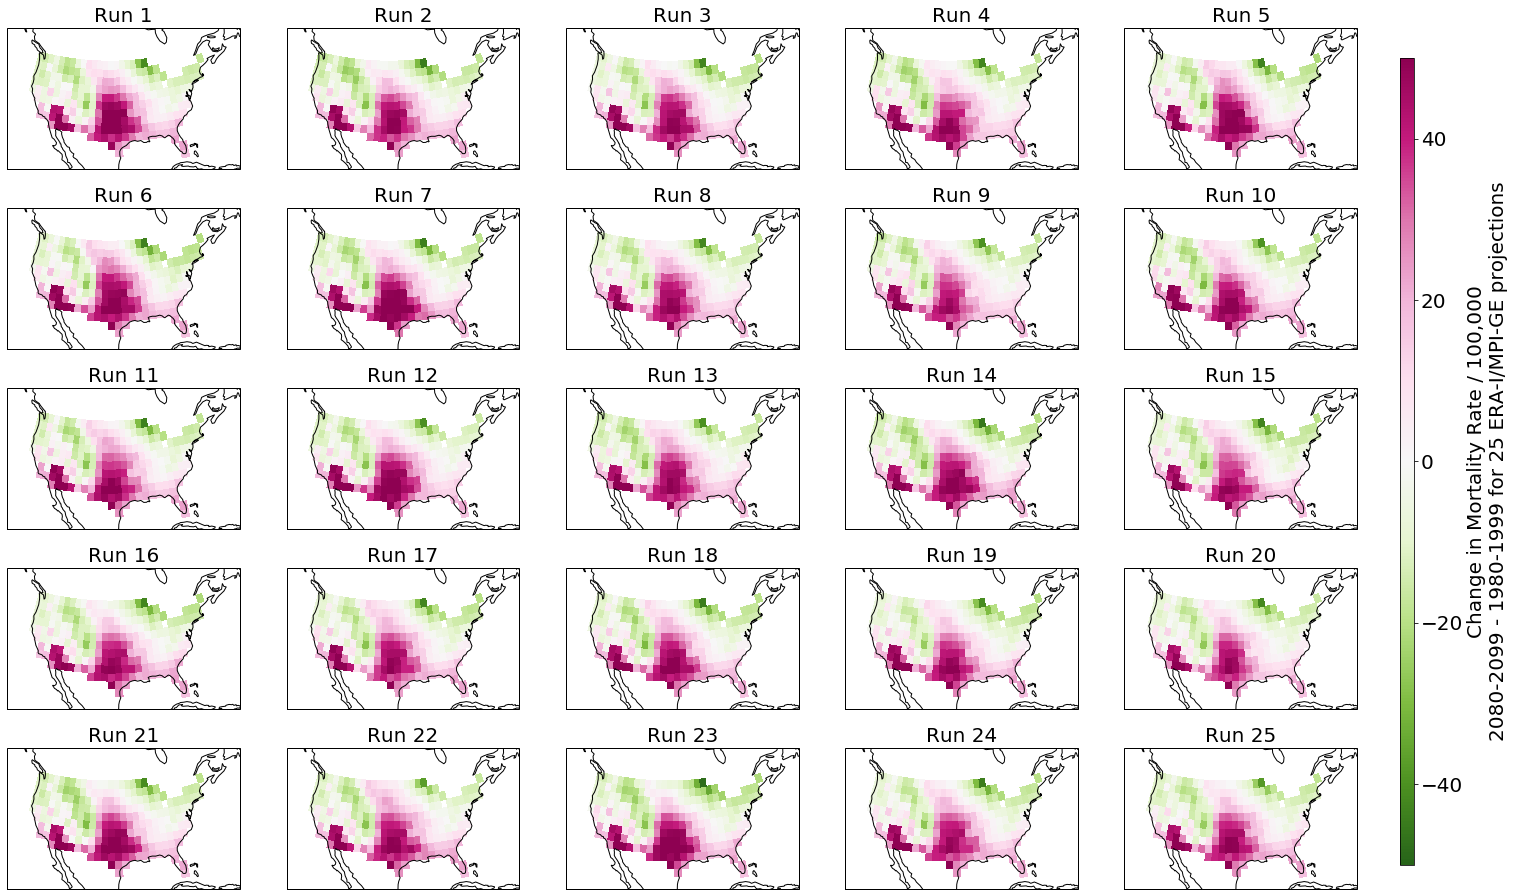

In [158]:
## Create figure
fig = plt.figure(figsize=(30,16))

# Set colormap
cmap = mpl.cm.get_cmap('PiYG_r')
# Set color limits
vs = [-50,50]

# #data_mpi_hist.run.values
for run_idx in np.arange(0,25):
    ax0 = plt.subplot(5, 5, run_idx+1, projection=ccrs.AlbersEqualArea(**proj_kwargs))
    (dbins.drate_endc[:,:,run_idx].where(mask==4)
         .plot(transform=ccrs.PlateCarree(),
           add_colorbar=False,
           cmap=cmap,vmin=vs[0],vmax=vs[1]))
    ax0.coastlines()
    ax0.set_extent((-125,-68,20,53))
    ax0.set_title('Run '+str(run_idx+1),size=20)
    
## Add the colorbar
# Bump everything over to make room for master colorbar
fig.subplots_adjust(right=0.75)
# Create axis for colorbar
cbar_ax = fig.add_axes([0.77, 0.15, 0.15, 0.7],visible=False)
# Add colorbar
cb=fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vs[0],vmax=vs[1]), 
                                   cmap=cmap),
                orientation='vertical',
            ax=cbar_ax,fraction=1,aspect=60)
cb.set_label("Change in Mortality Rate / 100,000\n2080-2099 - 1980-1999 for 25 ERA-I/MPI-GE projections",size=20)
cb.ax.tick_params(labelsize=20)

An example of changes in mortality rate based on 25 of the 50 created projections (analogous to the change in climatology figure for the same 25 runs, above). Changes in mortality rates seem consistent across runs, with some discrepancies in the upper midwest and as different magnitudes in Texas. 

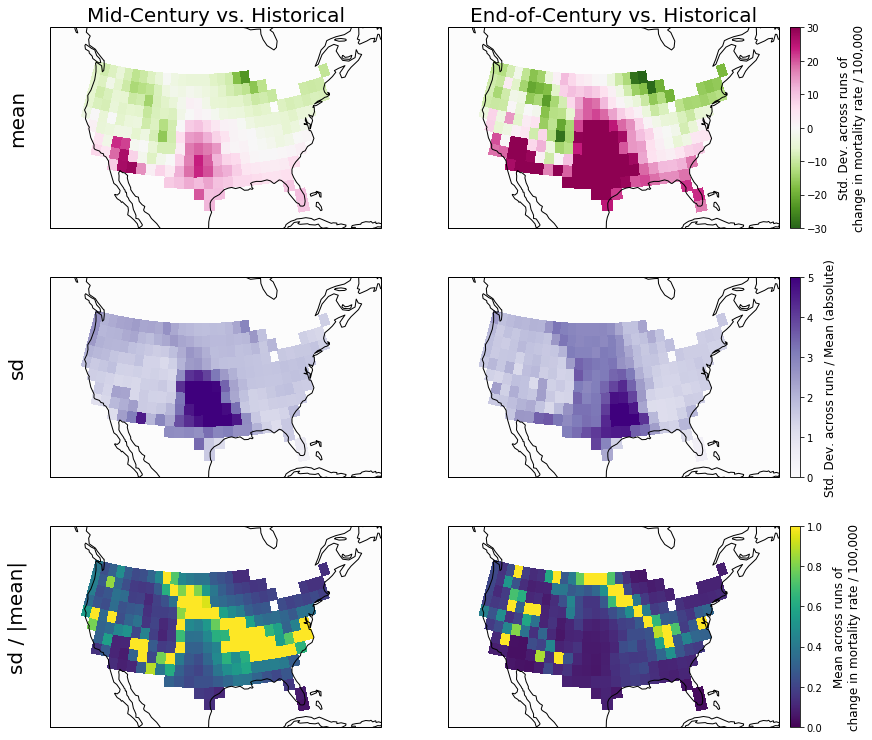

In [171]:
plot_params = {'data':[dbins.drate_midc.mean('run'),
                       dbins.drate_endc.mean('run'),
                       dbins.drate_midc.std('run'),
                       dbins.drate_endc.std('run'),
                       dbins.drate_midc.std('run')/np.abs(dbins.drate_midc.mean('run')),
                       dbins.drate_endc.std('run')/np.abs(dbins.drate_endc.mean('run'))],
               'titles':['Mid-Century vs. Historical','End-of-Century vs. Historical','','','',''],
               'ylabels':['mean','','sd','','sd / |mean|',''],
               'vs':[[-30,30],[-30,30],[0,5],[0,5],[0,1],[0,1]],
              'cmaps':['PiYG_r','PiYG_r','Purples','Purples','viridis','viridis'],
              'cbar_labels':['Mean across runs of\nchange in mortality rate / 100,000',
                            'Std. Dev. across runs of\nchange in mortality rate / 100,000',
                            'Std. Dev. across runs / Mean (absolute)']}

cmap = mpl.cm.get_cmap('RdBu_r')


## Plotting Function
def dmort_plot_setup(plot_params):
    axs = []
    fig = plt.figure(figsize=(15,13))
    for run_idx in np.arange(0,len(plot_params['data'])):
        ax = plt.subplot(len(plot_params['data'])/2, 2, run_idx+1, projection=ccrs.AlbersEqualArea(**proj_kwargs))
        (plot_params['data'][run_idx]
             .where(mask==4)
             .plot(transform=ccrs.PlateCarree(),
               add_colorbar=np.abs(np.remainder(run_idx,2))*False,
               cmap=mpl.cm.get_cmap(plot_params['cmaps'][run_idx]),
               vmin=plot_params['vs'][run_idx][0],vmax=plot_params['vs'][run_idx][1]))
        ax.coastlines(facecolor='grey')
        ax.set_extent((-125,-68,20,53))
        ax.set_title(plot_params['titles'][run_idx],size=20)
        ax.set_ylabel(plot_params['ylabels'][run_idx])
        ax.text(-0.07, 0.55, plot_params['ylabels'][run_idx], va='bottom', ha='center',
            rotation='vertical', rotation_mode='anchor',
            transform=ax.transAxes,size=20)
        ax.background_patch.set_facecolor((0.99,0.99,0.99))
        axs.append(ax)
    return((axs,fig))
# Run it
axs,fig=dmort_plot_setup(plot_params)



## Add the colorbar
def dmort_plot_cbar_setup(plot_params,axs,fig):
    # Bump everything over to make room for master colorbar
    fig.subplots_adjust(right=0.8)
    
    for run_idx in np.arange(0,int(len(plot_params['data'])/2)):
        # Get axis location from above
        tmp_pos = axs[run_idx*2-1].get_position().get_points()
        # Create axis for colorbar
        cbar_ax = fig.add_axes([0.81, tmp_pos[0,1], 0.15, tmp_pos[1,1]-tmp_pos[0,1]],visible=False)
        # Add colorbar
        cb=fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=plot_params['vs'][run_idx*2-1][0],
                                                                        vmax=plot_params['vs'][run_idx*2-1][1]), 
                                   cmap=plot_params['cmaps'][run_idx*2-1]),
                orientation='vertical',
            ax=cbar_ax,fraction=1,aspect=20)
        cb.set_label(plot_params['cbar_labels'][run_idx],size=12,labelpad=10)
        cb.ax.tick_params(labelsize=10)
        
# Run it
dmort_plot_cbar_setup(plot_params,axs,fig)

# Conclusions
From the final figure above, internal model variability in future projections of mortality changes may be relatively large in certain areas of the United States with small changes even in end-of-century, but are generally relatively small in areas of large projected mortality changes. By end-of-century, few pixels remain where the variability is close to the mean in magnitude. 

In other words, in this back-of-the-envelope calculation using a simple climate-mortality relationship (and ignoring adaptation, migration, technological changes, etc.), internal model variability seems to play a possible role in determining the sign of the signal in areas with small changes in mid-century, but become irrelevant across most of the continental United States by the end of the century.

Though no explicit modeling of inter-model or scenario uncertainty for comparison has been made in this project, this finding is in line with the Hawkins and Sutton conclusion for the climate variables underlying this study - while internal model variability may play a significant role in early- to mid-century projections, by end-of-century its impact may be limited. 

This conclusion cannot necessarily be generalized to many variables relevant to human impacts. Agricultural damage functions, for example, frequently involve thresholds or non-linearities much more striking than those found in heat-mortality studies. Since changes in variability have an outsized impact on threshold-defined extremes (see e.g. [Katz and Brown (1992)](https://link.springer.com/article/10.1007/BF00139728)), further study on a wider range of common damage functions should be undertaken. 